In [1]:
import pennylane as qml
from pprop.propagator import Propagator
import numpy as np

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os
from pathlib import Path
import tqdm

# Color cycle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


In [29]:
num_qubits_list = [2, 4, 6, 8, 10, 12]
connections = ['circular', 'linear', 'none']
depth = 1
num_samples = 1000
path = Path('/home/samonaco/dust/Pauli-Propagator/barrenplateau')

path.mkdir(parents=True, exist_ok=True)

In [3]:
def ansatz(params: list[float], num_qubits: int, depth: int, connectivity: str):
    index = 0

    for d in range(depth):
        # --- Single-qubit rotation layer ---
        for qubit in range(num_qubits):
            qml.RY(params[index], wires=qubit)
            index += 1
            qml.RX(params[index], wires=qubit)
            index += 1

        qml.Barrier()

        # --- Entangling layer ---
        if connectivity == 'none':
            pass  # No entanglement

        elif connectivity == 'linear':
            for i in range(num_qubits - 1):
                qml.CNOT(wires=[i, i + 1])

        elif connectivity == 'circular':
            for i in range(num_qubits - 1):
                qml.CNOT(wires=[i, i + 1])
            qml.CNOT(wires=[num_qubits - 1, 0])

        elif connectivity == 'all':
            for i in range(num_qubits):
                for j in range(i + 1, num_qubits):
                    qml.CNOT(wires=[i, j])

        else:
            raise ValueError("Connectivity must be one of {'none', 'linear', 'circular', 'all'}.")

        qml.Barrier()

    for qubit in range(num_qubits):
        qml.RY(params[index], wires=qubit)
        index += 1

    return qml.expval(sum(qml.PauliZ(i)/num_qubits for i in range(num_qubits)))

In [37]:
def get_variance(prop, n_samples=100):
    list_gvarC = []
    for _ in range(n_samples):
        theta = 4*np.pi*np.random.rand(prop.num_params) - 2*np.pi
        _, grads = prop.eval_and_grad(theta)
        gVarC = np.var(grads, axis=1)
        list_gvarC.append(gVarC)

    return list_gvarC

def get_magnitude(prop, n_samples=100):
    mag_dCdk = []
    for _ in range(n_samples):
        theta = 4*np.pi*np.random.rand(prop.num_params) - 2*np.pi
        _, grads = prop.eval_and_grad(theta)
        mag_dCdk.append(np.mean(np.abs(grads), axis = 1))

    return mag_dCdk

In [5]:
props = {}
progress = tqdm.tqdm(len(connections) * len(num_qubits_list))
for c in connections:
    props[c] = {}
    for n in num_qubits_list:
        progress.set_description(f'Propagating {c} ({n})')
        if not os.path.exists(path / f'{c}{n}'):
            prop = Propagator(lambda params: ansatz(params, num_qubits=int(n), depth=depth, connectivity=c),)
            prop.propagate(bar = False)
            prop.save(path / f'{c}{n}')
        else:
            prop = Propagator.load(path / f'{c}{n}')
        
        progress.update(1)

        props[c][n] = prop

Propagating circular (12): : 5it [00:00, 135.45it/s]

Propagating none (12): : 17it [00:00, 86.55it/s]    

In [6]:
VarsC = {}
for c in props:
    VarsC[c] = {}
    for n in props[c]:
        var = get_variance(props[c][n], n_samples=num_samples)
        VarsC[c][n] = var

Propagating none (12): : 18it [00:10, 86.55it/s]

In [7]:
def exp_model(n, a, b, c):
    """a * 2^(-b * n) + c"""
    return a * 2**(-b * n) + c

def poly_model(n, a, b, c):
    return a * (n**b) + c

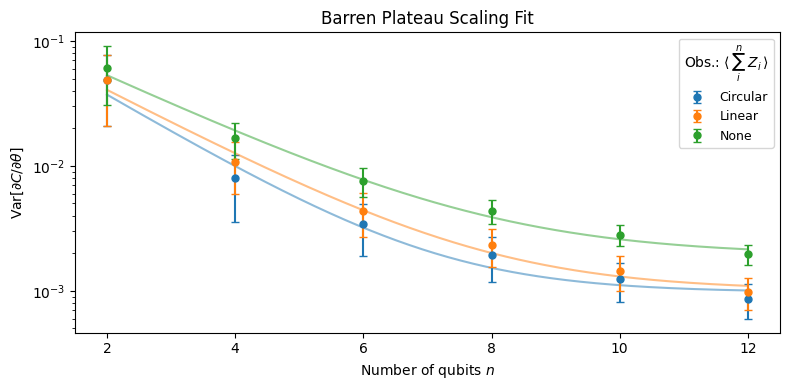

In [8]:
plt.figure(figsize=(8, 4))

for i, connectivity in enumerate(props):
    # Extract means for each number of qubits
    means = np.array([np.mean(VarsC[connectivity][nq]) for nq in num_qubits_list])
    stds = np.array([np.std(VarsC[connectivity][nq]) for nq in num_qubits_list])
    x = np.array(num_qubits_list)

    # Skip if data is too short
    if len(means) < 2:
        continue

    # --- Nonlinear fit with bounds ---
    try:
        popt, _ = curve_fit(
            exp_model,
            x,
            means,
            p0=(1.0, 0.5, 1e-8),           # initial guess
            bounds=([0, -0.5, 0], [np.inf, np.inf, np.inf]),
            maxfev=10000,
            sigma=means
        )
        a_fit, b_fit, c_fit = popt
    except RuntimeError:
        print(f"Fit failed for connectivity '{connectivity}'")
        continue

    # Smooth curve for plotting
    x_fit = np.linspace(min(x), max(x), 300)
    y_fit = exp_model(x_fit, a_fit, b_fit, c_fit)

    color = colors[i % len(colors)]

    # Scatter (data)
    plt.errorbar(
        x, 
        means,             # y values
        yerr=stds,         # vertical error bars
        fmt='o',           # marker style
        color=color,
        capsize=3,         # small horizontal line at the tip of error bars
        markersize=5,      # size of the marker
        label=connectivity.capitalize()         # optional, since the line will have the legend
    )

    # Line (fit)
    plt.plot(
        x_fit,
        y_fit,
        color=color,
        alpha=.5

    )

plt.xlabel("Number of qubits $n$")
plt.ylabel(r"$\mathrm{Var}[\partial C/\partial\theta]$")
plt.title("Barren Plateau Scaling Fit")
plt.yscale("log")

plt.legend(loc="upper right", fontsize=9,
           title=r"Obs.: $\langle\,\sum_i^n \;Z_i\,\rangle$"
)
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Number of Propagated Pauli Word')

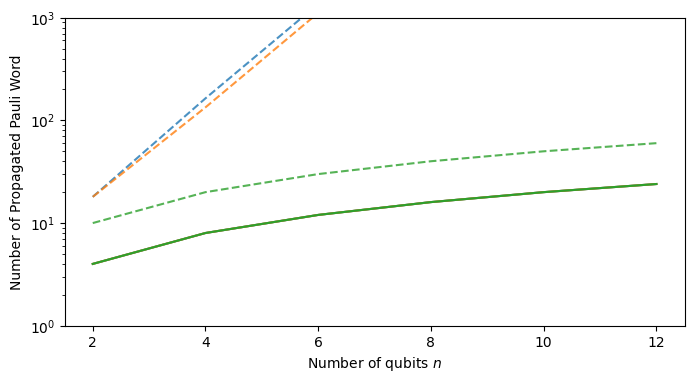

In [10]:
# Color cycle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure(figsize=(8, 4))
for i, connectivity in enumerate(props):
    num_obs = [len(prop.histW) for prop in props[connectivity].values()]
    num_obs_trim = [len(prop.trim_histW) for prop in props[connectivity].values()]
    plt.plot(x, num_obs, ls='--', color=colors[i % len(colors)], alpha = .8)
    plt.plot(x, num_obs_trim, color=colors[i % len(colors)], label=connectivity.capitalize())
    plt.ylim((1, 1000))
    plt.yscale("log")
plt.xlabel("Number of qubits $n$")
plt.ylabel("Number of Propagated Pauli Word")


Text(0, 0.5, 'Average Frequency')

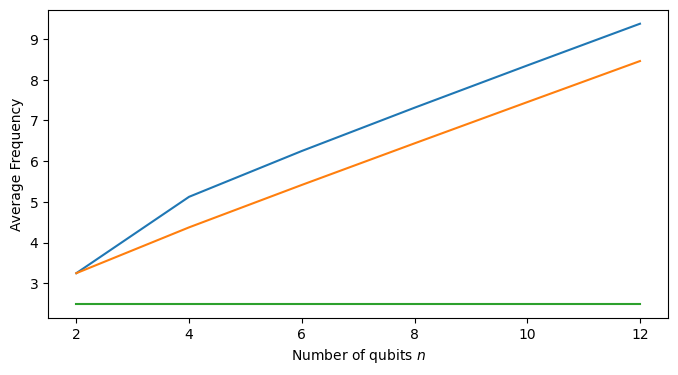

In [11]:
# Color cycle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure(figsize=(8, 4))
for i, connectivity in enumerate(props):
    avg_freq = [np.mean(prop.histF) for prop in props[connectivity].values()]
    avg_freq_trim = [np.mean(prop.trim_histF) for prop in props[connectivity].values()]
    # plt.plot(n_vals, avg_freq, ls='--', color=colors[i % len(colors)], alpha = .8)
    plt.plot(x, avg_freq_trim, color=colors[i % len(colors)], label=connectivity.capitalize())
    # plt.yscale("log")
plt.xlabel("Number of qubits $n$")
plt.ylabel("Average Frequency")

In [12]:
def qcnn(params, num_qubits):
    def wall(wires, rot_fun, params, index):
        for wire in wires:
            rot_fun(params[index], wires=int(wire))
            index += 1
        return index

    def conv(wires, params, index):
        p_group = []
        if len(wires) % 4 == 0:
            p_group = wires.reshape(-1, 4)
        elif len(wires) % 2 == 0:
            p_group = wires.reshape(-1, 2)
        else:
            p_group = wires[:-1].reshape(-1, 2)
            qml.RX(params[index], wires=int(wires[-1]))
            index += 1

        for wires_group in p_group:
            for wire1, wire2 in zip(wires_group[0::1], wires_group[1::1]):
                qml.CNOT(wires=[int(wire1), int(wire2)])
            for wire in wires_group:
                qml.RY(params[index], wires=int(wire))
                index += 1

        return index

    def pool(wires, params, index):
        is_even = len(wires) % 2 == 0

        for wire_meas, wire_next in zip(wires[0::2], wires[1::2]):
            qml.RX(params[index], wires=int(wire_meas))
            qml.CNOT(wires=[int(wire_meas), int(wire_next)])
            index = index + 1

            # Removing measured wires from active_wires:
            wires = np.delete(wires, np.where(wires == wire_meas))

        # ---- > If the number of wires is odd, the last wires is not pooled
        #        so we apply a gate
        if not is_even:
            qml.RX(params[index], wires=int(wires[-1]))
            index = index + 1

        return index, wires

    # Wires that are not measured (through pooling)
    wires_active = np.arange(num_qubits)

    # Index of the parameter vector
    index = 0

    # index = wall(wires_active, qml.RX, params, index)
    # index = wall(wires_active, qml.RY, params, index)
    index = wall(wires_active, qml.RY, params, index)

    while len(wires_active) > 1:
        # Convolute
        index = conv(wires_active, params, index)
        # Pool
        index, wires_active = pool(wires_active, params, index)

        qml.Barrier()

    # index = conv(wires_active, params, index)
    index = wall(wires_active, qml.RY, params, index)

    # Return the number of parameters
    return [qml.expval(qml.PauliZ(wire)) for wire in wires_active]


In [13]:
props_qcnn = {}
for qubit in num_qubits_list:
    if not os.path.exists(path / f'qcnn{qubit}'):
        prop = Propagator(lambda params: qcnn(params, num_qubits=qubit), k1 = None, k2= None)
        prop.propagate(bar = False)
        prop.save(path / f'qcnn{qubit}')
    else:
        prop = Propagator.load(path / f'qcnn{qubit}')
    props_qcnn[qubit] = prop


In [38]:
magsC_qcnn = {}
for qubit in props_qcnn:
    magsC_qcnn[qubit] = get_magnitude(props_qcnn[qubit], n_samples=num_samples)

In [30]:
VarsC_qcnn = {}
for qubit in props_qcnn:
    VarsC_qcnn[qubit] = get_variance(props_qcnn[qubit], n_samples=num_samples)

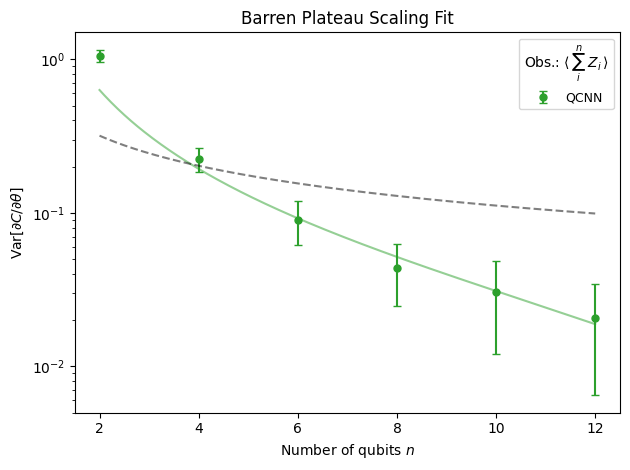

In [45]:
true_fun = lambda x: 1 / (2 * x **(np.log2(np.pi) - 1))
# Color cycle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

means = np.array([np.sum(magsC_qcnn[qubit])/(50*props_qcnn[qubit].num_params) for qubit in props_qcnn])
stds = np.array([np.std(magsC_qcnn[qubit]) for qubit in props_qcnn])
n_vals = np.array(list(props_qcnn.keys())).astype(int)

# --- Nonlinear fit with bounds ---
try:
    popt, _ = curve_fit(
        poly_model,
        n_vals,
        means,
        p0=(0.5, -np.log2(np.pi)+1, 1e-8),           # initial guess
        bounds=([0, -5, -1], [2, 5, 1]),
        maxfev=10000,
        sigma=means
    )
    a_fit, b_fit, c_fit = popt
except RuntimeError:
    print(f"⚠️ Fit failed for connectivity '{connectivity}'")

# Smooth curve for plotting
n_fit = np.linspace(min(n_vals), max(n_vals), 300)
y_fit = poly_model(n_fit, a_fit, b_fit, c_fit)

color = colors[i % len(colors)]

# Scatter (data)
plt.errorbar(
    n_vals,            # x values
    means,             # y values
    yerr=stds,         # vertical error bars
    fmt='o',           # marker style
    color=color,
    capsize=3,         # small horizontal line at the tip of error bars
    markersize=5,      # size of the marker
    label='QCNN'         # optional, since the line will have the legend
)

# Line (fit)
plt.plot(
    n_fit,
    y_fit,
    color=color,
    alpha=.5

)

# Line (fit)
plt.plot(
    n_fit,
    true_fun(n_fit),
    color='black',
    alpha=.5,
    ls='--'


)

plt.xlabel("Number of qubits $n$")
plt.ylabel(r"$\mathrm{Var}[\partial C/\partial\theta]$")
plt.title("Barren Plateau Scaling Fit")
plt.yscale("log")

plt.legend(loc="upper right", fontsize=9,
           title=r"Obs.: $\langle\,\sum_i^n \;Z_i\,\rangle$"
)
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Number of Propagated Pauli Word')

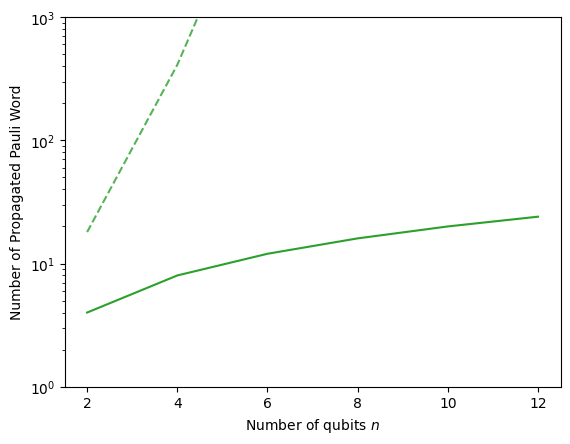

In [32]:
num_obs = [len(prop.histW) for prop in props_qcnn.values()]
num_obst_trim = [len(prop.trim_histW) for prop in props_qcnn.values()]
plt.plot(n_vals, num_obs, ls='--', color=colors[i % len(colors)], alpha = .8)
plt.plot(n_vals, num_obs_trim, color=colors[i % len(colors)], label=connectivity.capitalize())
plt.ylim((1, 1000))
plt.yscale("log")
plt.xlabel("Number of qubits $n$")
plt.ylabel("Number of Propagated Pauli Word")

Text(0, 0.5, 'Average Frequency')

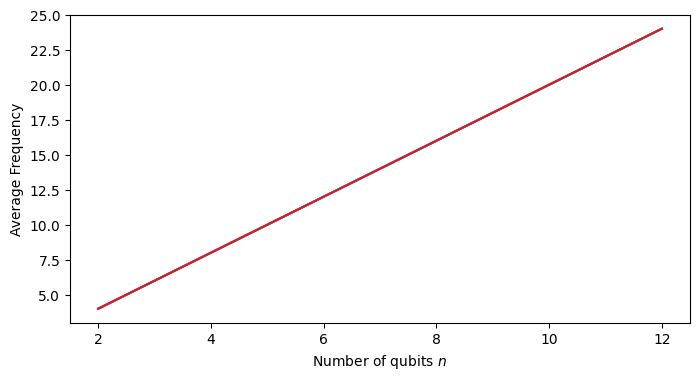

In [33]:
plt.figure(figsize=(8, 4))
for i, connectivity in enumerate(props):
    # num_obs = [len(prop.histW) for prop in props[connectivity].values()]
    num_obs_trim = [len(prop.trim_histW) for prop in props[connectivity].values()]
    # plt.plot(n_vals, num_obs, ls='--', color=colors[i % len(colors)], alpha = .8)
    plt.plot(n_vals, num_obs_trim, color=colors[i % len(colors)], label=connectivity.capitalize())
# plt.plot(n_vals, num_obs, ls='--', color=colors[i % len(colors)], alpha = .8)
plt.plot(n_vals, num_obs_trim, color='crimson', label=connectivity.capitalize())
plt.xlabel("Number of qubits $n$")
plt.ylabel("Average Frequency")